In [102]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [103]:
from treebuilder import ft2treebuilder

#reload the treebuilder module
import importlib
importlib.reload(ft2treebuilder)


<module 'treebuilder.ft2treebuilder' from '/home/dmoi/projects/foldtree2/treebuilder/ft2treebuilder.py'>

In [104]:

tb = ft2treebuilder.treebuilder( model = 'godnodemk5_contactmlp_hbond_nogeo' )

In [105]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch

In [106]:
modelname = 'godnodemk5_contactmlp_hbond_nogeo'

encoder_save = 'godnodemk5_contactmlp_hbond_nogeo'
decoder_save = 'godnodemk5_contactmlp_hbond_nogeo'
overwrite = False

with open( 'godnodemk5_contactmlp_hbond_nogeo.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)


In [107]:
print( decoder)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-3): 4 x HeteroConv(num_relations=4)
  )
  (bn): BatchNorm1d(276, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=300, out_features=250, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): GELU(approximate='none')
    (5): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
  )
  (aadecoder): Sequential(
    (0): Linear(in_features=526, out_features=100, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=100, out_features=20, bias=True)
    (5)

In [108]:
datadir = '../../datasets/'
model_dir = 'models/'

outdir_base = '../../results/foldtree2/'

if not os.path.exists(outdir_base):
	os.makedirs(outdir_base)

#output for matrices 
matdir = outdir_base + 'matrices/'
if not os.path.exists(matdir):
	os.makedirs(matdir)

#output for trees
treedir = outdir_base + 'trees/'
if not os.path.exists(treedir):
	os.makedirs(treedir)

In [109]:
#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [110]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [111]:
mkdirs = False
if mkdirs == True:
	#make a structure alignment directory
	if not os.path.exists( 'struct_align' ):
		os.makedirs( 'struct_align' )
	
	#make a directory for each cluster representative
	for rep in reps['repId']:
		if not os.path.exists( datadir +'struct_align/' + rep  ):
			os.makedirs(datadir + 'struct_align/' + rep  )
		if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
			os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
			

In [112]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
	n = 5
	for rep in tqdm.tqdm(reps.repId.unique() ):
		subdf = reps[ reps['repId'] == rep ]
		if len(subdf) < n:
			n = len(subdf)
		subdf = subdf.sample( n = n  )
		subdf = subdf.head( n )
		#download the structures
		for uniID in subdf['entryId']:
			AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [113]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
	for rep in tqdm.tqdm(reps.repId.unique() ):
		#align the structures
		foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [114]:
import foldtree2_ecddcd as ft2
import importlib
importlib.reload(ft2)

import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)


['families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/4HJ1.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/6EGU.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/1OAN.pdb']


In [115]:

from converter import pdbgraph
converter = pdbgraph.PDB2PyG()

In [116]:
ndim = 844
alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#device = torch.device('cpu')
print(device)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.eval()

cuda:0


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): GATv2Conv(857, 100, heads=4)
      (res_hbond_res): GATv2Conv(857, 100, heads=4)
    )
    (1): ModuleDict(
      (res_contactPoints_res): GATv2Conv(100, 100, heads=4)
      (res_hbond_res): GATv2Conv(100, 100, heads=4)
    )
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (lin): Sequential(
    (0): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
  )
  (out_dense): Sequential(
    (0): Linear(in_features=120, out_features=300, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): GELU(approximate='none')
    (4): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (5): Linear(in_features=300, out_features=20, bias=True)
    (6): Tanh()
  )
  (ve

In [117]:
from torch_geometric.data import DataLoader
struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=False)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader):
		for data in loader:
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )



/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
12530it [17:42, 11.79it/s]


In [118]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''

seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

print(encoded_df)

127800it [00:00, 1194851.86it/s]


                                                          seq
protid                                                       
A0A009NC05  $(&"!$\t$&(!$...
A0A011NNG3  #\t"(\t...
A0A011P981  ## ' ...
A0A011Q6F0  ##\t#%(#"!#...
A0A011TX23  ##!!!!\t$"\t#\t   ...
...                                                       ...
X8C4D9      ## "$%%!$...
X8CW14      #### (#&...
X8F2F7      ### # #%\t%# "%&&...
X8IXX3      #\t\t\t\t...
X8JSL8      #  %% #%...

[12529 rows x 1 columns]


In [119]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [120]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq
protid                                                       
A0A009NC05  $(&ø!$\t$&(!$...
A0A011NNG3  ÷\tø(\t...
A0A011P981  ÷÷ý'ý...
A0A011Q6F0  ÷÷\t÷%(÷ø!÷...
A0A011TX23  ÷÷!!!!\t$ø\t÷\týýý...
...                                                       ...
X8C4D9      ÷÷ýø$%%!$...
X8CW14      ÷÷÷÷ý(÷&...
X8F2F7      ÷÷÷ý÷ý÷%\t%÷ýø%&&...
X8IXX3      ÷\t\t\t\t...
X8JSL8      ÷ýý%%ý÷%...

[12529 rows x 1 columns]


In [121]:
#embedding starts at 0
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A009NC05  $(&ø!$\t$&(!$...   
A0A011NNG3  ÷\tø(\t...   
A0A011P981  ÷÷ý'ý...   
A0A011Q6F0  ÷÷\t÷%(÷ø!÷...   
A0A011TX23  ÷÷!!!!\t$ø\t÷\týýý...   

                                                          ord  \
protid                                                          
A0A009NC05  [23, 23, 3, 36, 40, 19, 3, 14, 6, 4, 8, 23, 38...   
A0A011NNG3  [247, 21, 12, 9, 17, 31, 15, 20, 20, 21, 20, 2...   
A0A011P981  [247, 247, 253, 14, 6, 16, 29, 20, 4, 6, 15, 3...   
A0A011Q6F0  [247, 247, 6, 31, 17, 31, 5, 9, 21, 4, 247, 12...   
A0A011TX23  [247, 247, 2, 21, 33, 26, 24, 16, 14, 33, 33, ...   

                                                         hex2  
protid                      

In [122]:
from torch_geometric.data import HeteroData
import torch_geometric
import torch
torch.autograd.set_detect_anomaly(True)


from scipy import sparse

converter = ft2.PDB2PyG()


In [123]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A016SYZ7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

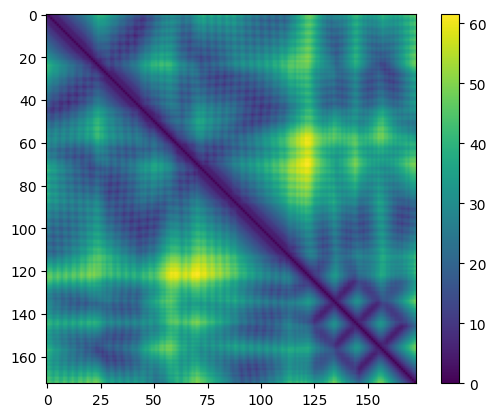

158
HeteroData(
  res={
    x=[158, 276],
    batch=[158],
  },
  positions={ x=[158, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 157] },
  (res, backbone_rev, res)={ edge_index=[2, 157] },
  (godnode4decoder, informs, res)={ edge_index=[2, 158] },
  (res, informs, godnode4decoder)={ edge_index=[2, 158] },
  (res, informs, godnode)={ edge_index=[2, 158] }
)
torch.Size([24964, 1])
tensor([[-9.7190e+00, -1.3443e+01, -1.3600e+01,  ..., -8.0410e+00,
         -1.4604e+01, -1.0141e+01],
        [-3.5416e+00, -9.0168e+00, -8.8622e+00,  ..., -8.0763e+00,
         -1.0236e+01, -6.5054e+00],
        [-1.6305e+01, -1.1620e+01, -1.4624e+01,  ..., -8.6154e+00,
         -1.4181e+01, -1.6832e+01],
        ...,
        [-8.7441e+00, -1.0371e+01, -1.2704e+01,  ..., -9.0271e+00,
         -6.9550e+00, -2.3831e-03],
        [-1.1945e+01, -1.3608e+01, -1.4459e+01,  ..., -1.6553e+01,
         -1.3097e+01, -1.2868e+01],
        [-7.2185e+00, -1.3076

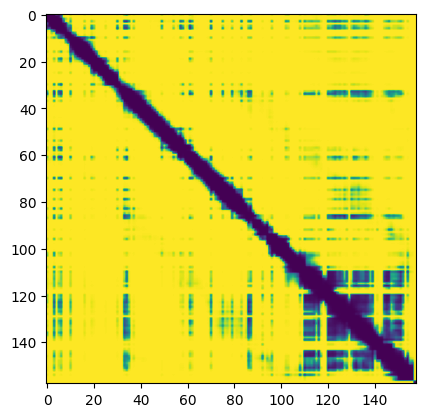

(158, 158)
(173, 173)


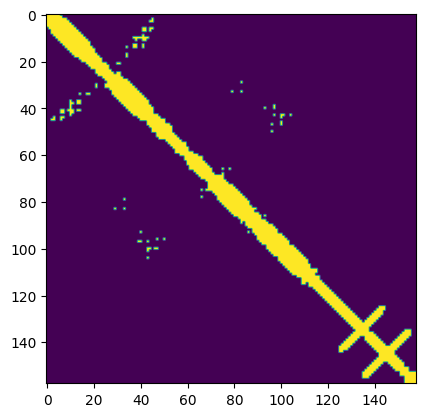

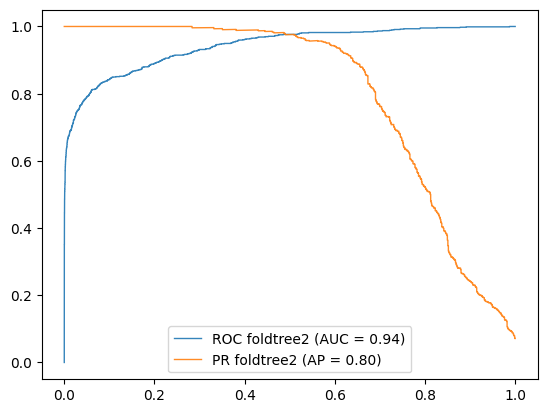

A0A016T9X9


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

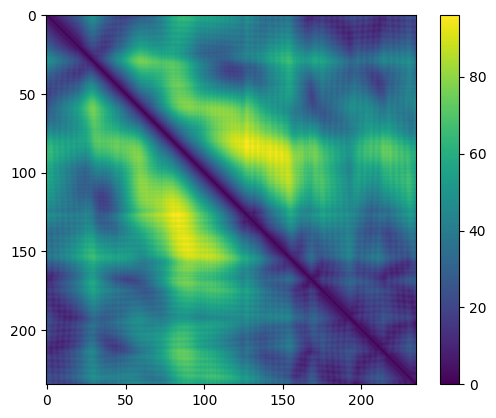

216
HeteroData(
  res={
    x=[216, 276],
    batch=[216],
  },
  positions={ x=[216, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 215] },
  (res, backbone_rev, res)={ edge_index=[2, 215] },
  (godnode4decoder, informs, res)={ edge_index=[2, 216] },
  (res, informs, godnode4decoder)={ edge_index=[2, 216] },
  (res, informs, godnode)={ edge_index=[2, 216] }
)
torch.Size([46656, 1])
tensor([[ -9.7347, -13.4513, -13.4511,  ...,  -8.0251, -14.3851, -10.0170],
        [ -9.7788, -13.3714, -13.6324,  ...,  -8.0397, -14.6307, -10.1954],
        [ -9.1544, -14.9247, -14.4356,  ...,  -6.7131, -10.7469,  -6.9513],
        ...,
        [ -8.8568, -13.2456, -14.0864,  ..., -12.4997, -14.2259, -12.9540],
        [-11.4126, -11.8009, -12.6189,  ..., -16.9150, -13.2427, -11.0860],
        [ -6.7925, -11.2507, -12.3261,  ..., -11.4627, -11.4440, -10.0337]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[9.9969e-01, 9.9968e-01,

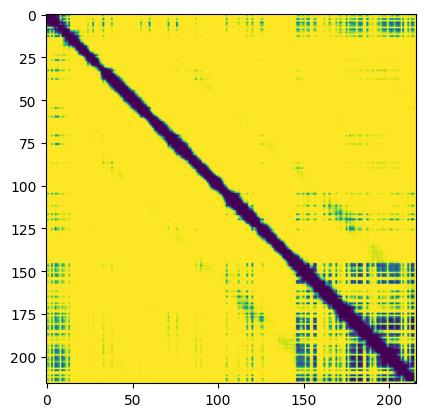

(216, 216)
(235, 235)


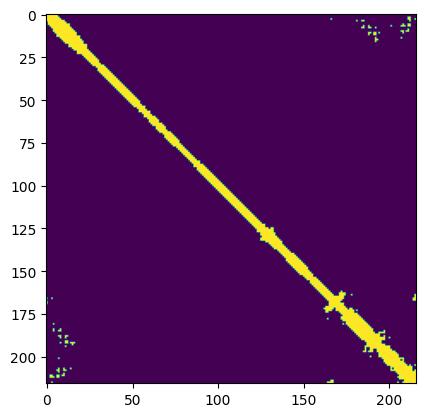

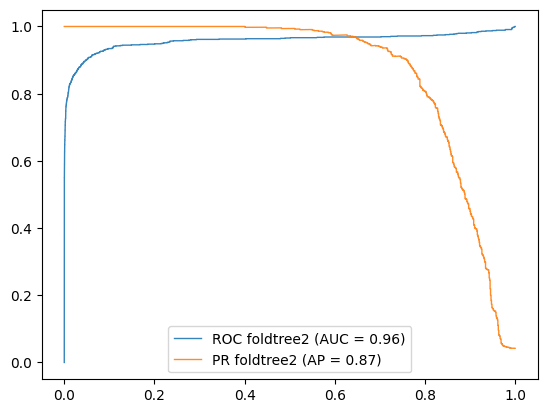

A0A016TJ96


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

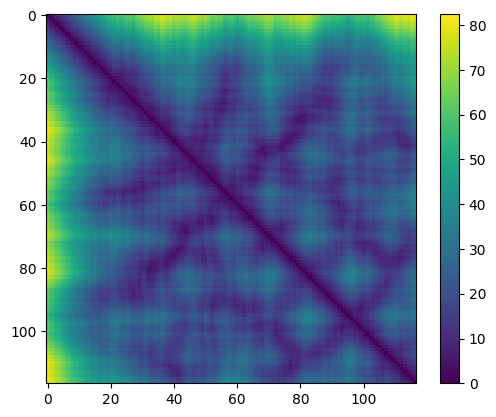

112
HeteroData(
  res={
    x=[112, 276],
    batch=[112],
  },
  positions={ x=[112, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 111] },
  (res, backbone_rev, res)={ edge_index=[2, 111] },
  (godnode4decoder, informs, res)={ edge_index=[2, 112] },
  (res, informs, godnode4decoder)={ edge_index=[2, 112] },
  (res, informs, godnode)={ edge_index=[2, 112] }
)
torch.Size([12544, 1])
tensor([[-9.7067e+00, -1.3395e+01, -1.3650e+01,  ..., -8.0804e+00,
         -1.4674e+01, -1.0223e+01],
        [-9.7173e+00, -1.3319e+01, -1.3763e+01,  ..., -8.0895e+00,
         -1.4845e+01, -1.0311e+01],
        [-1.4552e+01, -1.3921e+01, -8.1907e+00,  ..., -9.4430e+00,
         -9.1455e+00, -1.2971e+01],
        ...,
        [-1.9211e-03, -1.3399e+01, -1.2475e+01,  ..., -9.2954e+00,
         -1.1384e+01, -1.1392e+01],
        [-8.7737e+00, -1.0599e+01, -1.2798e+01,  ..., -9.1594e+00,
         -7.0836e+00, -2.2569e-03],
        [-1.1872e+01, -1.3619

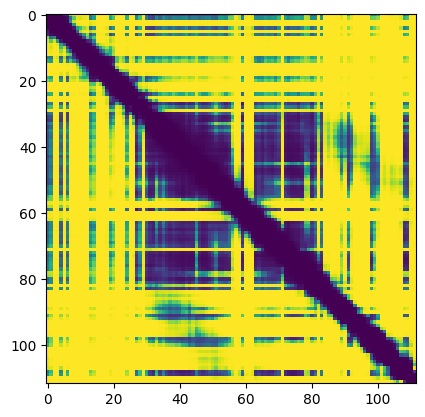

(112, 112)
(117, 117)


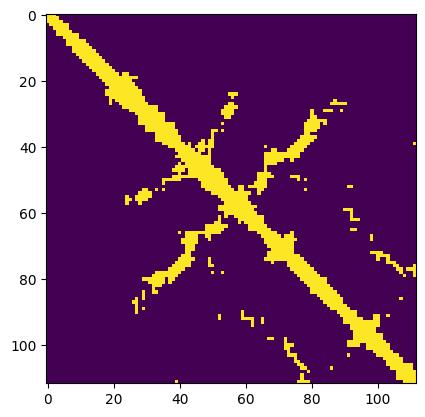

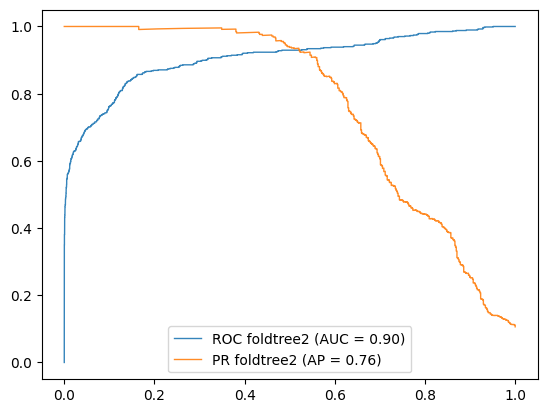

A0A016TMN9


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

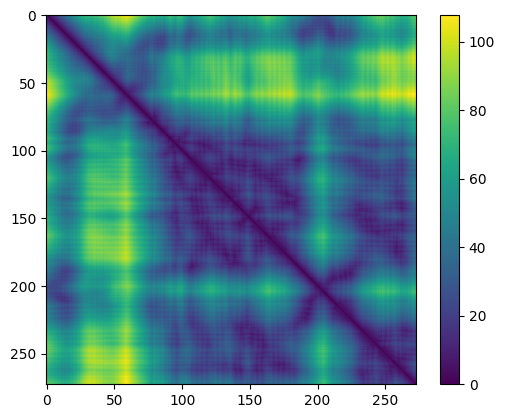

261
HeteroData(
  res={
    x=[261, 276],
    batch=[261],
  },
  positions={ x=[261, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 260] },
  (res, backbone_rev, res)={ edge_index=[2, 260] },
  (godnode4decoder, informs, res)={ edge_index=[2, 261] },
  (res, informs, godnode4decoder)={ edge_index=[2, 261] },
  (res, informs, godnode)={ edge_index=[2, 261] }
)
torch.Size([68121, 1])
tensor([[ -9.7378, -13.4916, -13.4859,  ...,  -7.9420, -14.4453, -10.0362],
        [ -9.7193, -13.4432, -13.7134,  ...,  -8.0256, -14.7219, -10.2607],
        [ -6.1410, -11.9756, -12.7592,  ..., -12.3508, -11.7138, -10.7451],
        ...,
        [-10.0348, -11.7560,  -9.2459,  ..., -13.5200, -12.6598, -11.4463],
        [-10.4983, -13.9876, -13.7713,  ...,  -8.2131, -11.6228,  -6.0058],
        [ -9.9883, -11.5459,  -8.4864,  ..., -13.5134, -12.5560, -11.0719]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[9.9978e-01, 9.9966e-01,

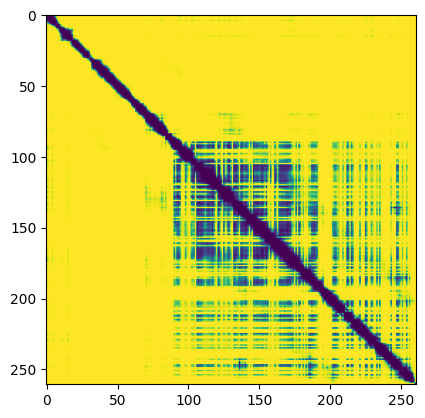

(261, 261)
(273, 273)


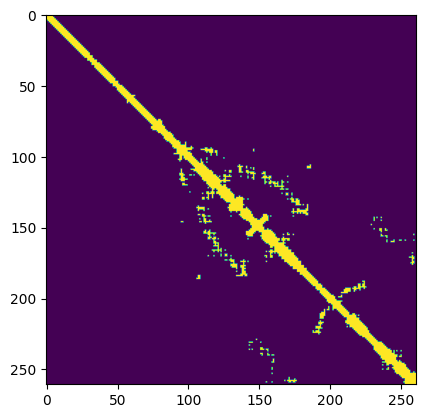

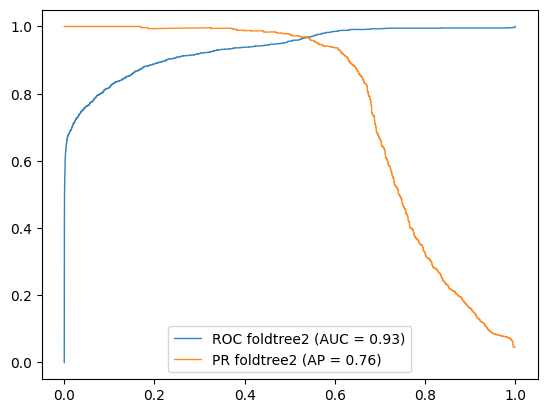

A0A016TMY0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

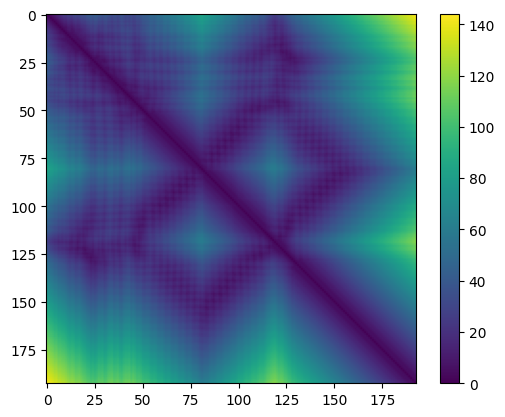

179
HeteroData(
  res={
    x=[179, 276],
    batch=[179],
  },
  positions={ x=[179, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 178] },
  (res, backbone_rev, res)={ edge_index=[2, 178] },
  (godnode4decoder, informs, res)={ edge_index=[2, 179] },
  (res, informs, godnode4decoder)={ edge_index=[2, 179] },
  (res, informs, godnode)={ edge_index=[2, 179] }
)
torch.Size([32041, 1])
tensor([[ -9.7444, -13.4233, -13.5865,  ...,  -7.9872, -14.6216, -10.1827],
        [ -9.7266, -13.3407, -13.7580,  ...,  -8.0308, -14.8278, -10.3346],
        [ -8.2903, -13.4362, -13.9284,  ...,  -7.4632, -14.1860, -10.9804],
        ...,
        [ -7.3800, -13.1432, -13.5242,  ...,  -6.5227, -13.0620, -11.1051],
        [-11.9342,  -8.9540,  -8.4174,  ..., -17.2024,  -9.2934,  -9.7222],
        [-10.0664, -11.5191,  -8.4356,  ..., -13.2769, -12.3801, -11.4788]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[9.9975e-01, 9.9977e-01,

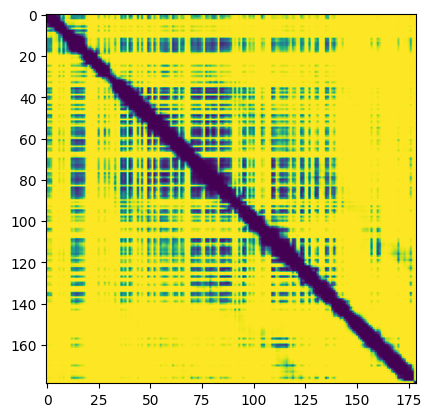

(179, 179)
(193, 193)


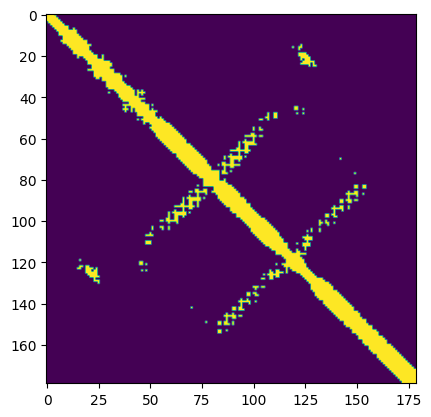

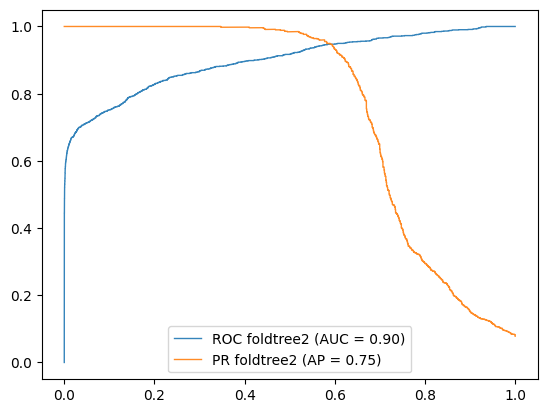

A0A016UCK1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

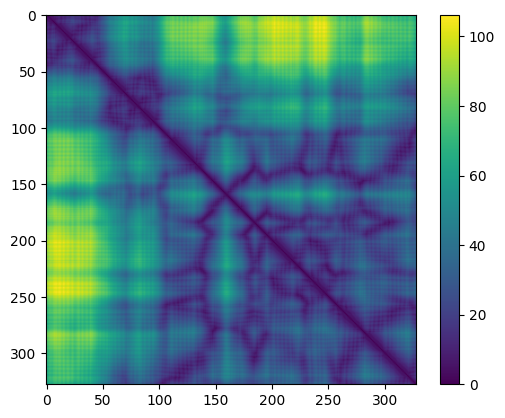

317
HeteroData(
  res={
    x=[317, 276],
    batch=[317],
  },
  positions={ x=[317, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 316] },
  (res, backbone_rev, res)={ edge_index=[2, 316] },
  (godnode4decoder, informs, res)={ edge_index=[2, 317] },
  (res, informs, godnode4decoder)={ edge_index=[2, 317] },
  (res, informs, godnode)={ edge_index=[2, 317] }
)
torch.Size([100489, 1])
tensor([[ -9.6857, -13.4737, -13.4876,  ...,  -7.9454, -14.4943, -10.1221],
        [ -9.6371, -13.4005, -13.7325,  ...,  -7.9884, -14.7499, -10.3251],
        [ -9.0386, -11.1589, -10.3748,  ..., -13.3730, -13.8340, -10.3791],
        ...,
        [ -9.1184, -13.7128, -14.6046,  ..., -12.3720, -14.1741, -13.7029],
        [-15.8519, -12.0055, -16.7793,  ..., -11.4211, -16.6047, -17.8635],
        [-11.2935, -15.4736, -15.3293,  ...,  -6.1769, -10.8418, -17.4520]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[9.9966e-01, 9.9960e-01

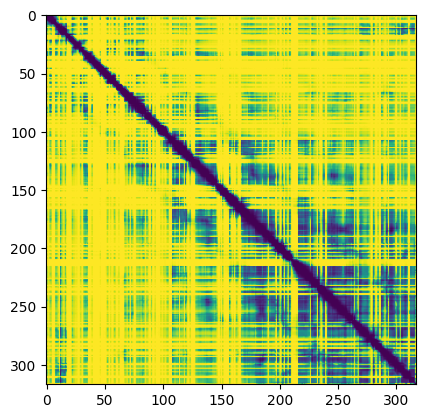

(317, 317)
(328, 328)


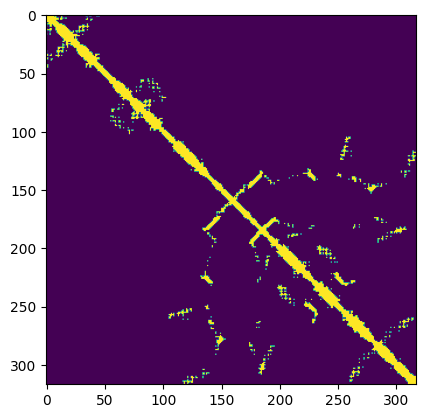

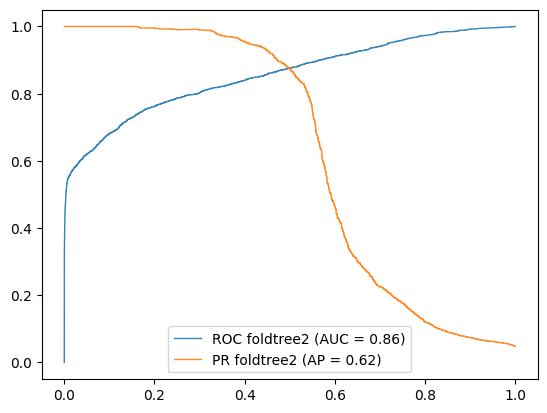

A0A016VD21


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

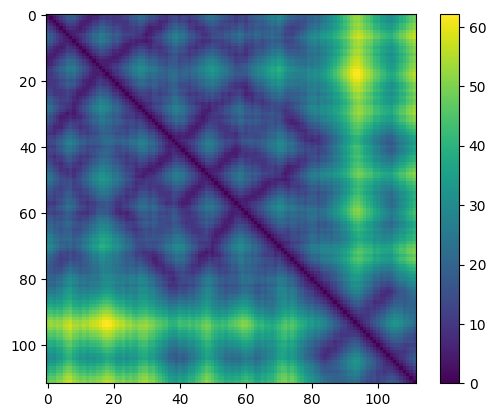

110
HeteroData(
  res={
    x=[110, 276],
    batch=[110],
  },
  positions={ x=[110, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 109] },
  (res, backbone_rev, res)={ edge_index=[2, 109] },
  (godnode4decoder, informs, res)={ edge_index=[2, 110] },
  (res, informs, godnode4decoder)={ edge_index=[2, 110] },
  (res, informs, godnode)={ edge_index=[2, 110] }
)
torch.Size([12100, 1])
tensor([[-9.6213e+00, -1.3354e+01, -1.3723e+01,  ..., -8.1102e+00,
         -1.4719e+01, -1.0314e+01],
        [-9.6158e+00, -1.3266e+01, -1.3726e+01,  ..., -8.1140e+00,
         -1.4759e+01, -1.0264e+01],
        [-8.7670e+00, -1.2071e+01, -1.0659e+01,  ..., -1.1537e+01,
         -1.2074e+01, -1.1209e+01],
        ...,
        [-1.6401e+01, -1.1529e+01, -1.5202e+01,  ..., -8.5598e+00,
         -1.4003e+01, -1.6870e+01],
        [-8.6364e+00, -1.0441e+01, -1.2803e+01,  ..., -8.7342e+00,
         -6.5862e+00, -2.9663e-03],
        [-1.0063e+01, -1.1620

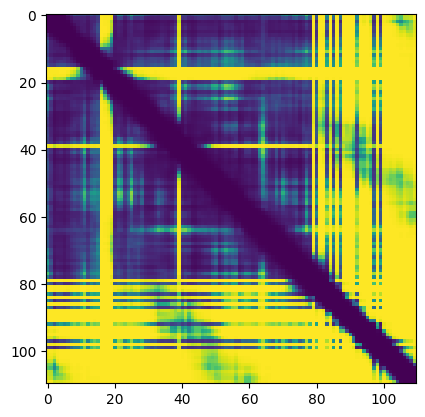

(110, 110)
(112, 112)


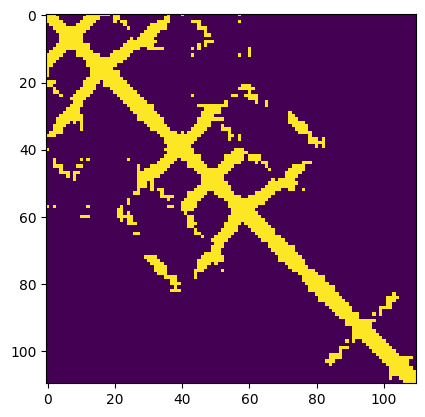

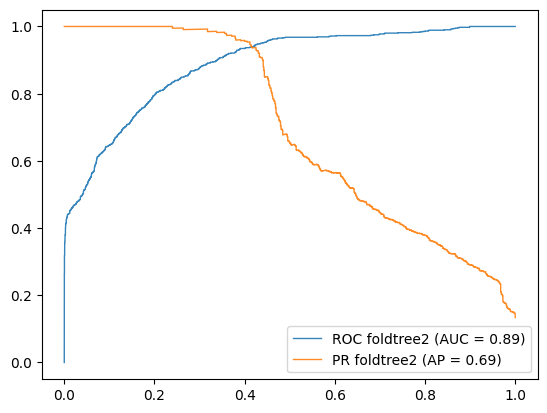

A0A016VUL7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

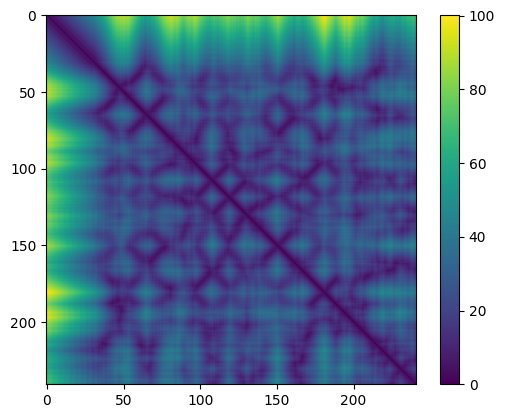

233
HeteroData(
  res={
    x=[233, 276],
    batch=[233],
  },
  positions={ x=[233, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 232] },
  (res, backbone_rev, res)={ edge_index=[2, 232] },
  (godnode4decoder, informs, res)={ edge_index=[2, 233] },
  (res, informs, godnode4decoder)={ edge_index=[2, 233] },
  (res, informs, godnode)={ edge_index=[2, 233] }
)
torch.Size([54289, 1])
tensor([[-9.3333e+00, -1.3458e+01, -1.3649e+01,  ..., -7.9975e+00,
         -1.4538e+01, -1.0331e+01],
        [-9.2811e+00, -1.3396e+01, -1.3719e+01,  ..., -8.0052e+00,
         -1.4650e+01, -1.0354e+01],
        [-8.3867e+00, -1.0307e+01, -1.3313e+01,  ..., -9.2110e+00,
         -6.8907e+00, -2.3257e-03],
        ...,
        [-6.9749e-04, -9.9590e+00, -9.4474e+00,  ..., -1.1795e+01,
         -1.1055e+01, -1.4239e+01],
        [-8.6616e+00, -1.3831e+01, -1.4625e+01,  ..., -1.2402e+01,
         -1.4393e+01, -1.3389e+01],
        [-1.1325e+01, -9.0638

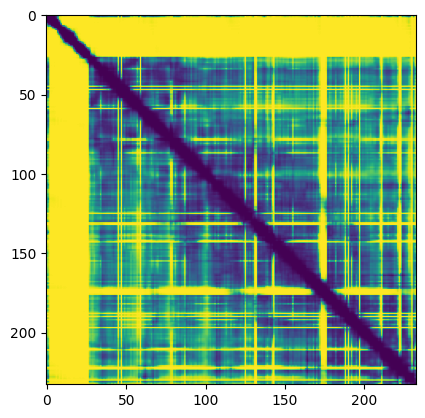

(233, 233)
(241, 241)


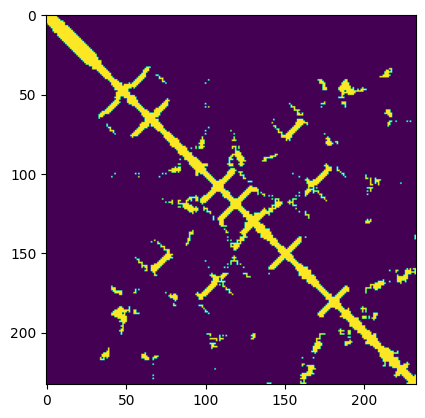

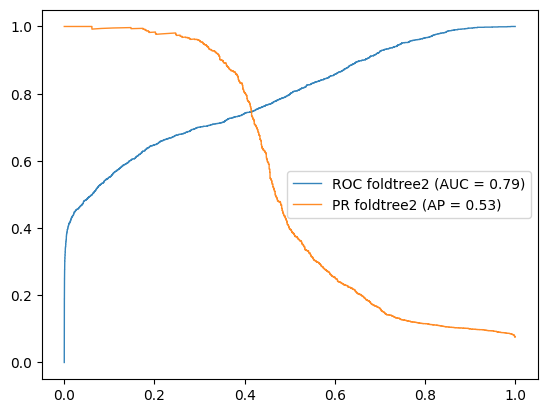

A0A016WCN4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

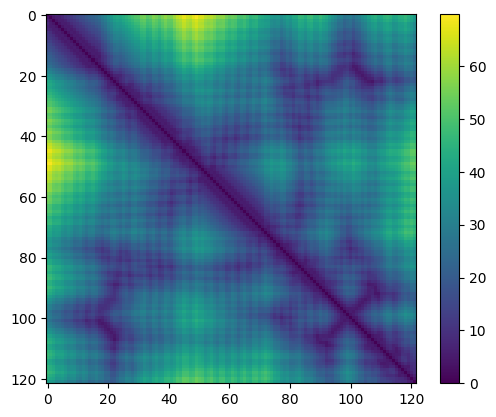

104
HeteroData(
  res={
    x=[104, 276],
    batch=[104],
  },
  positions={ x=[104, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 103] },
  (res, backbone_rev, res)={ edge_index=[2, 103] },
  (godnode4decoder, informs, res)={ edge_index=[2, 104] },
  (res, informs, godnode4decoder)={ edge_index=[2, 104] },
  (res, informs, godnode)={ edge_index=[2, 104] }
)
torch.Size([10816, 1])
tensor([[ -9.7093, -13.4169, -13.6204,  ...,  -8.1028, -14.6215, -10.1697],
        [ -9.7337, -13.3434, -13.7401,  ...,  -8.0996, -14.8001, -10.2784],
        [-13.2381, -11.2666,  -8.5939,  ..., -13.7109, -13.4936, -15.8330],
        ...,
        [-12.0136,  -9.4342,  -8.7733,  ..., -17.2733,  -9.4255,  -9.6009],
        [ -9.7935, -11.6611,  -8.3237,  ..., -13.5484, -12.2412, -11.8039],
        [-13.1101, -10.9539,  -7.6679,  ..., -14.1608, -13.6390, -15.8766]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[9.9964e-01, 9.9967e-01,

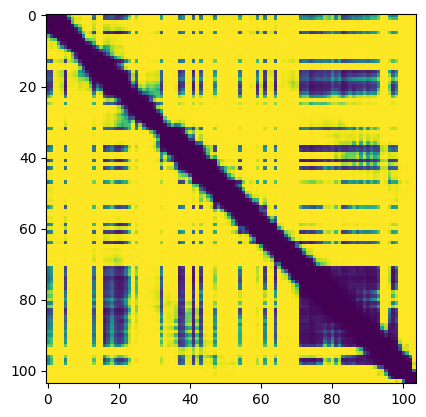

(104, 104)
(122, 122)


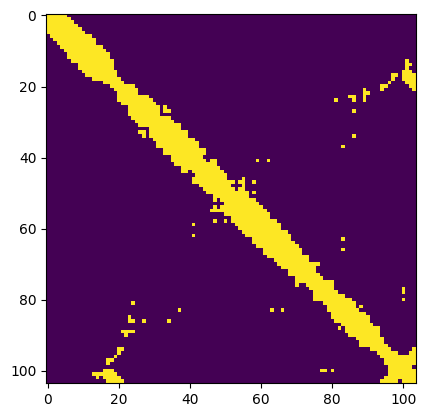

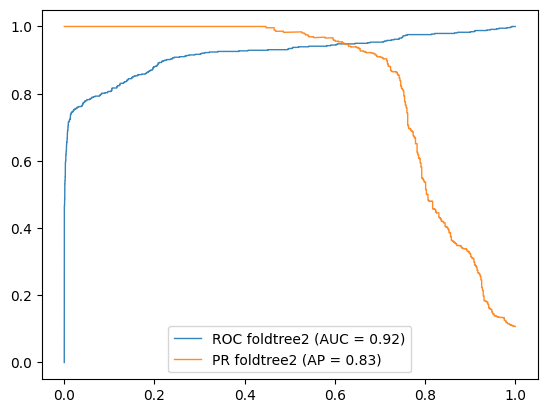

A0A016X0I5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

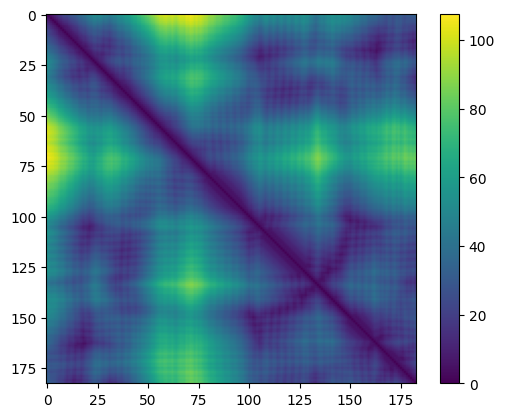

168
HeteroData(
  res={
    x=[168, 276],
    batch=[168],
  },
  positions={ x=[168, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 167] },
  (res, backbone_rev, res)={ edge_index=[2, 167] },
  (godnode4decoder, informs, res)={ edge_index=[2, 168] },
  (res, informs, godnode4decoder)={ edge_index=[2, 168] },
  (res, informs, godnode)={ edge_index=[2, 168] }
)
torch.Size([28224, 1])
tensor([[-9.7274e+00, -1.3456e+01, -1.3525e+01,  ..., -8.0508e+00,
         -1.4486e+01, -1.0066e+01],
        [-9.7530e+00, -1.3392e+01, -1.3716e+01,  ..., -8.0603e+00,
         -1.4737e+01, -1.0246e+01],
        [-1.1423e+01, -1.3901e+01, -1.4140e+01,  ..., -1.6021e+01,
         -1.2993e+01, -1.2102e+01],
        ...,
        [-1.0496e+01, -1.4241e+01, -1.3606e+01,  ..., -8.4865e+00,
         -1.1791e+01, -5.8822e+00],
        [-9.0052e+00, -1.0671e+01, -1.2441e+01,  ..., -9.0719e+00,
         -7.0721e+00, -2.3716e-03],
        [-8.8693e+00, -1.4694

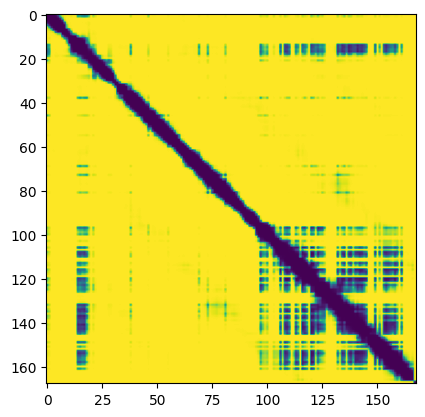

(168, 168)
(183, 183)


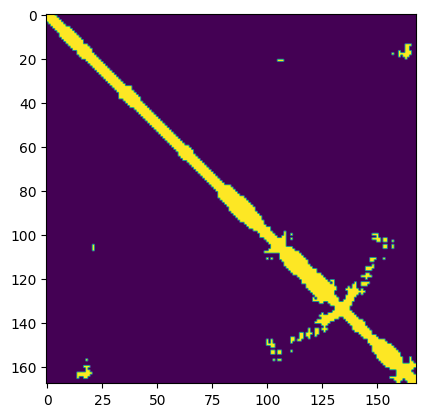

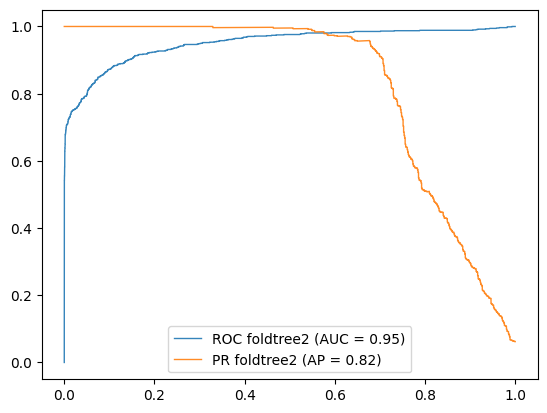

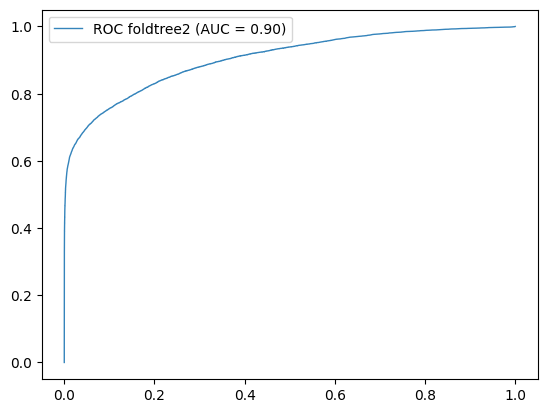

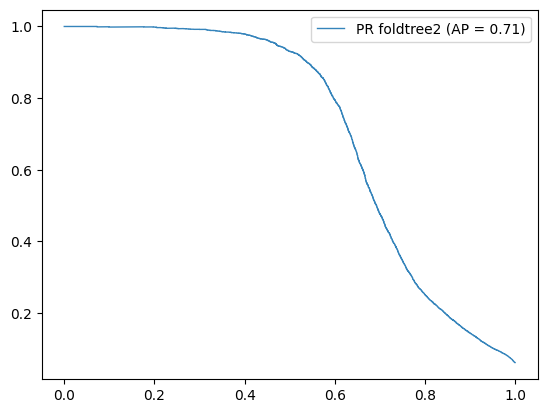

In [125]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res'].x = torch.cat([data['res'].x, data['positions'].x], dim=1)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles= decoder( data , allpairs ) 
	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( 10, 20):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct

	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')

	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	
	#cutoff = 10
	#s[s > cutoff] = 0
	#plt.imshow(s)
	#plt.colorbar()
	#plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = probs.numpy()
	probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs))
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [172]:
print( encoded_df)

                                                          seq  \
protid                                                          
A0A453QQV3  !!÷÷ø!ø...   
A0A4P7WVZ7  $$$ø$øø$$÷ø...   
A0A0D6M027  !$øø÷!$$!ø!ø÷ø...   
W6MC04      $$÷!!!$!!!÷...   
A0A0W0GEV3  ø!$ø÷$$...   
...                                                       ...   
A0A397I8A3  ø$ø$$ø$!$$...   
A0A6J2V4T5  $ø÷!$øøø!ø...   
X6NIZ4      ø$÷$...   
A0A3M1CSX7  ý$!!ý$...   
A0A2E3RFR4  $÷$$$$ø$...   

                                                          ord  \
protid                                                          
A0A453QQV3  [26, 24, 8, 33, 20, 2, 1, 1, 26, 33, 33, 8, 2,...   

In [173]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
	char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )
ordset = set( [ ord(c) for c in char_set ] )    
print( ordset )

['\x01', '\x02', '\x04', '\x05', '\x06', '\x07', '\x08', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', '(', '÷', 'ø', 'ý']
34
{1, 2, 4, 5, 6, 7, 8, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36, 37, 38, 40, 247, 248, 253}


In [174]:
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')
fident_thresh = .3
submat =  np.zeros((256,256))
background_freq = np.zeros(len(char_set))
q_mat = np.zeros((256,256))
seqcount = 0


In [175]:

for rep in tqdm.tqdm(alnfiles ):
	q_mat_chunk = np.zeros((256,256))
	submat_chunk = np.zeros((256,256))
	alncount = 0
	#load the all vs all aln
	aln_df = pd.read_table(rep)
	aln_df.columns = cols
	#load the embedding of the structures
	q = aln_df['query'].unique()
	t = aln_df['target'].unique()
	
	seqset = set()
	representative = rep.split('/')[-2]
	for q in aln_df['query'].unique():
		for t in aln_df['target'].unique():
			if q != t:
				#align the structures
				aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
				if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
					aln = aln.iloc[0]
					qaln = aln.qaln
					taln = aln.taln
					qaccession = q.split( '.' )[0]
					taccession = t.split( '.' )[0]

					if qaccession in encoded_df.index and taccession in encoded_df.index:
						qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
						tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

						if qaccession not in seqset:
							background_freq += np.array([ qz.count( c ) for c in char_set ])
							seqset.add( qaccession )
							seqcount += len(qz)
							
						if taccession not in seqset:
							background_freq += np.array([ tz.count( c ) for c in char_set ])
							seqset.add( taccession )
							seqcount += len(tz)
						

						if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
							qz = iter(qz)
							tz = iter(tz)

							#transfer the alignments to the embeddings                    
							qaln_ft2, taln_ft2 = [], []

							for q_char in qaln:
								if q_char == '-':
									qaln_ft2.append(None)
								else:
									qaln_ft2.append(ord(next(qz)))
								   
							for t_char in taln.strip():
								if t_char == '-':
									taln_ft2.append(None)
								else:
									taln_ft2.append(ord(next(tz)))

							alnzip = list(zip( qaln_ft2 , taln_ft2 ))
							alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
							#normalize by size of alignment
							
							submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
							#normalize by size of alignment and number of pairs
							alncount += 1
							q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
		if alncount > 0:
			submat += (submat_chunk / alncount)

100%|███████████████████| 3691/3691 [00:44<00:00, 83.71it/s]


In [176]:
ordset = np.array(list(ordset))
print(ordset)

[  1   2   4   5   6   7   8  11  12  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  29  30  31  33  36  37  38  40 247 248 253]


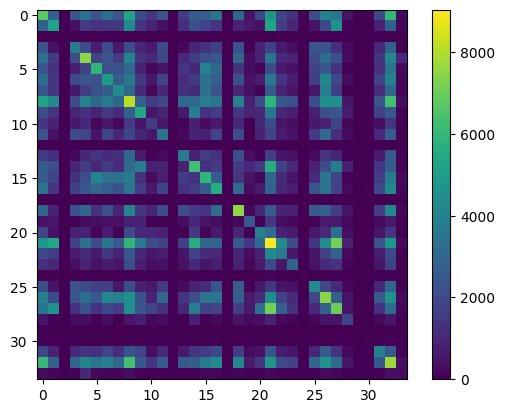

In [181]:
mafft_mat = submat[ordset , :] 
mafft_mat = mafft_mat[ : , ordset ]
mafft_mat = (mafft_mat + mafft_mat.T) / 2
plt.imshow(mafft_mat)
plt.colorbar()


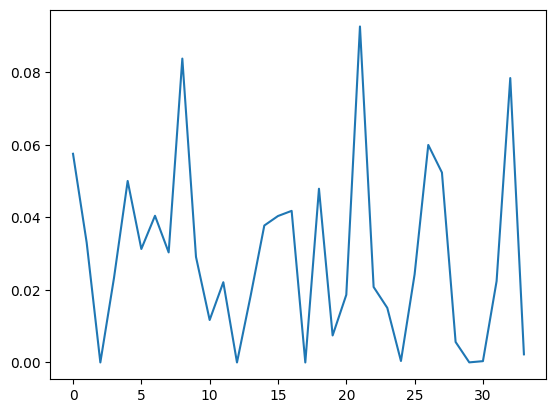

In [182]:
plt.plot( background_freq / sum(background_freq) )

In [183]:
import numpy as np

def compute_log_odds_from_counts(
	pair_counts: np.ndarray,
	char_freqs: np.ndarray,
	pseudocount: float = 1e-6,
	log_base: float = np.e
) -> np.ndarray:
	"""
	Computes a log-odds ratio matrix from a pair-count matrix and a vector of character frequencies.

	Parameters
	----------
	pair_counts : np.ndarray (n x n)
		pair_counts[i, j] = number of times character i is aligned with character j.
	char_freqs : np.ndarray (n,)
		char_freqs[i] = background frequency of character i.
	pseudocount : float
		Small value added to avoid division by zero.
	log_base : float
		Base of the logarithm (np.e for natural log, 2 for log base 2, 10 for log base 10, etc.).

	Returns
	-------
	log_odds_matrix : np.ndarray (n x n)
		log_odds_matrix[i, j] = log-odds ratio for substituting character i with character j.
	"""

	# 1. Validate input dimensions
	n = pair_counts.shape[0]
	if pair_counts.shape[1] != n:
		raise ValueError("pair_counts must be an n x n matrix.")
	if char_freqs.shape[0] != n:
		raise ValueError("char_freqs must have length n.")

	# 2. Compute total sum of pair counts (for normalization)
	total_pairs = np.sum(pair_counts)

	# 3. Compute observed frequencies with pseudocount
	#    obs_freq[i, j] = (pair_counts[i, j] + pseudocount) / (total_pairs + pseudocount_factor)
	#    You can scale pseudocount_factor as you see fit; for simplicity, we'll just add pseudocount to numerator
	obs_freq = (pair_counts + pseudocount) / (total_pairs + pseudocount * (n**2))

	# 4. Compute expected frequencies using background frequencies
	#    exp_freq[i, j] = char_freqs[i] * char_freqs[j]
	#    Note: if your background frequencies do not sum to 1, you may need to normalize them first
	exp_freq = np.outer(char_freqs, char_freqs) + pseudocount

	# 5. Compute log-odds ratio
	#    ratio[i, j] = obs_freq[i, j] / exp_freq[i, j]
	ratio = obs_freq / exp_freq

	#    log_odds[i, j] = log(ratio[i, j]) / log(log_base)
	#    We add a small epsilon to avoid log(0.0) if ratio < 1e-15, etc.
	epsilon = 1e-15
	log_odds_matrix = np.log(ratio + epsilon) / np.log(log_base)

	return log_odds_matrix


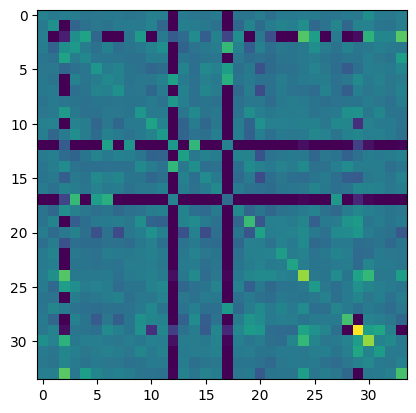

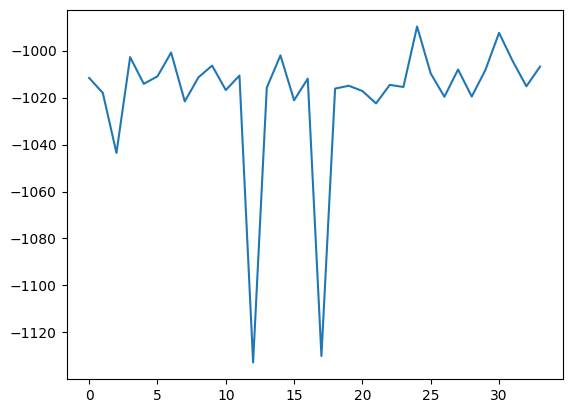

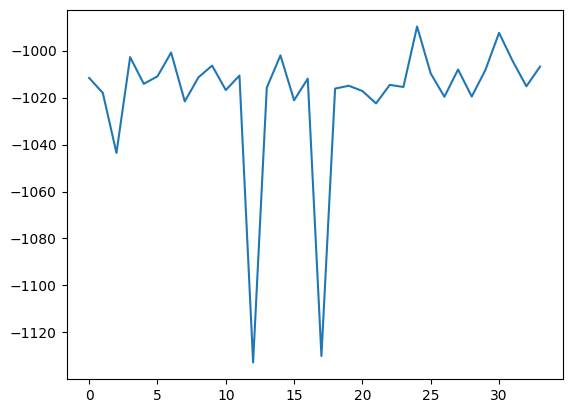

2606333.0


In [184]:
log_odds = compute_log_odds_from_counts(mafft_mat, background_freq )
plt.imshow(log_odds)

plt.show()

plt.plot(np.sum(log_odds , axis= 0) )

plt.show()
plt.plot(np.sum(log_odds , axis= 1) )
plt.show()
print( np.sum( background_freq ) )

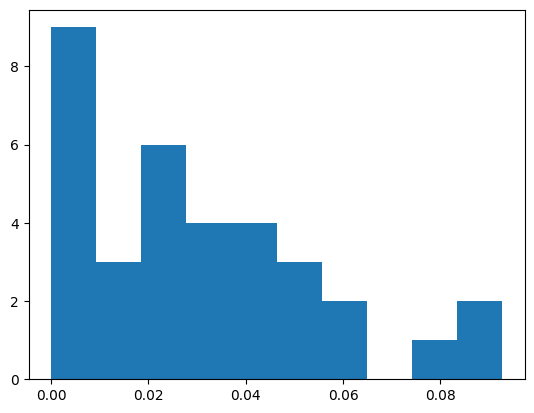

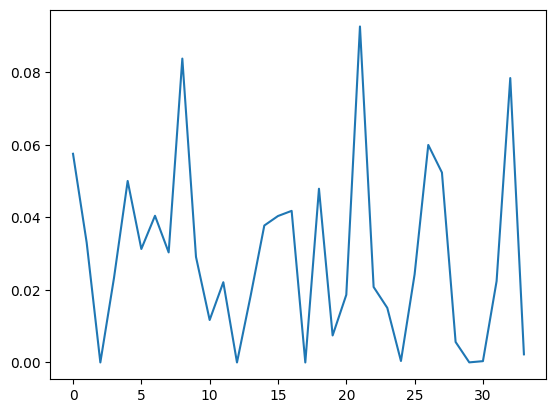

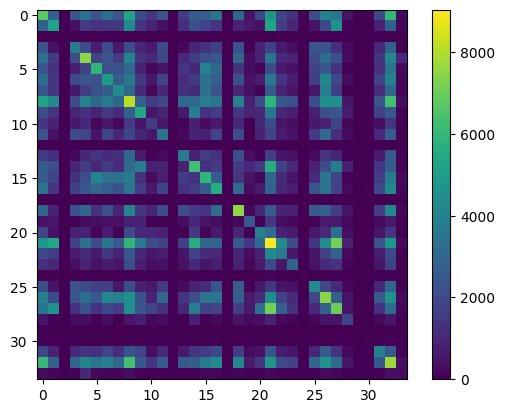

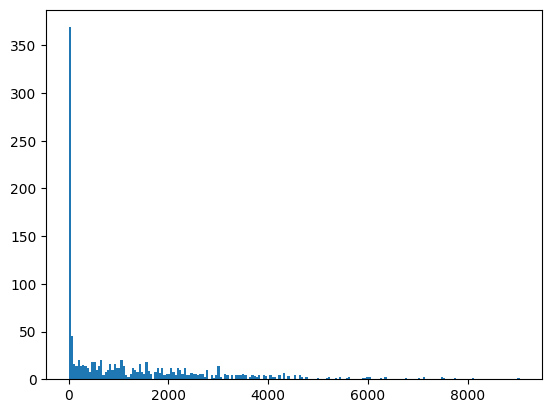

In [186]:
background_freq = background_freq / np.sum( background_freq )
submat = submat + submat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()
#ploT QMAT
plt.imshow(mafft_mat)
plt.colorbar()
plt.show()
plt.hist(mafft_mat.flatten() , bins = 200)
plt.show()


In [187]:
ords = np.array([ ord(c) for c in char_set ])
ords_original = ords.copy()
ords_original = sorted([ i if i not in rev_replace_dict_ord else rev_replace_dict_ord[i] for i in ords ])

print(ords)
print( ords_original)


[  1   2   4   5   6   7   8  11  12  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  29  30  31  33  36  37  38  40 247 248 253]
[1, 2, 4, 5, 6, 7, 8, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40]


In [126]:
import copy
print( char_set)
print( [ ord(c) for c in char_set ] )
alphabet = [ord(c) for c in char_set]
#set the tick marks to the alphabet
plt.figure( figsize=(10,10))
plt.xticks( range(len(char_set)), char_set)
plt.yticks( range(len(char_set)), char_set )
plt.imshow(mafft_mat)

count_mat = copy.deepcopy(mafft_mat)

NameError: name 'char_set' is not defined

In [127]:
import numpy as np
import math

# Initialize frequency matrix and total count
total_pairs = np.sum(mafft_mat)
# Calculate observed frequencies q_ij
mafft_mat = mafft_mat / total_pairs

# Calculate amino acid frequencies p_i
p_vector = np.sum(mafft_mat, axis=0)

# Calculate expected frequencies e_ij = p_i * p_j
e_matrix = np.outer(p_vector, p_vector)

# Calculate log-odds scores S_ij = log2(q_ij / e_ij)
# Note: We add a small constant to avoid division by zero
log_odds_matrix = np.log2((mafft_mat + 1e-10) / (e_matrix + 1e-10))

# Scaling the log-odds scores (optional, here multiplied by 2 and rounded)
scaled_log_odds_matrix = np.round(log_odds_matrix * 2)
# Print the BLOSUM matrix
print("BLOSUM-like Matrix:")
print(scaled_log_odds_matrix)



NameError: name 'mafft_mat' is not defined

<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1816168/4160199976.py:3: SyntaxWarning: invalid escape sequence '\ '
  inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()


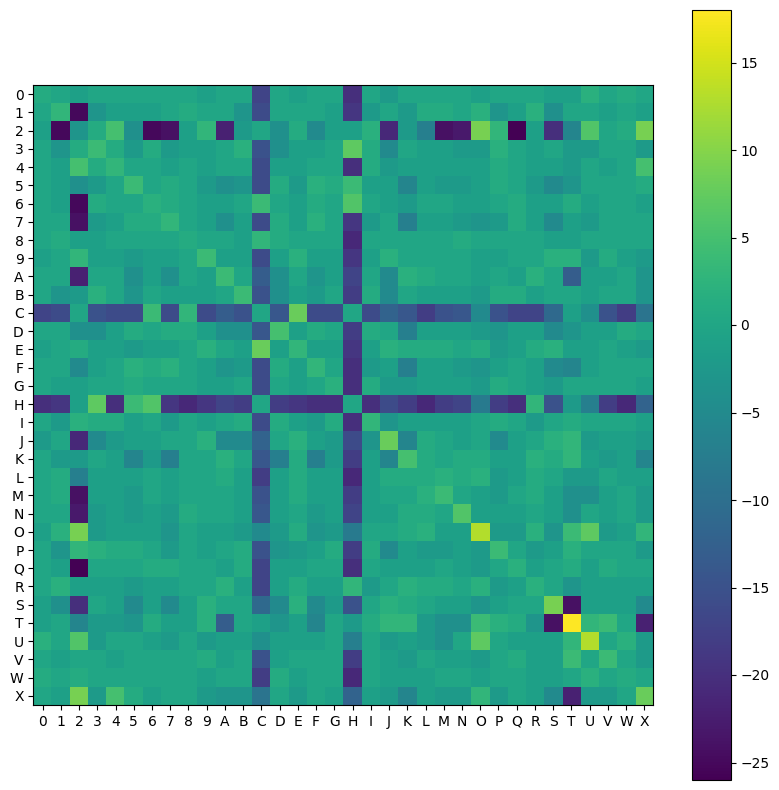

In [190]:
#raxml mat
import copy
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()

revmap_raxml = { c:ords[i] for i,c in enumerate(inputchars[:len(char_set)]) }
map_raxml = { ords[i]:c for i,c in enumerate(inputchars[:len(char_set)]) }
raxml_alphabet = inputchars[:len(char_set)]


plt.figure( figsize=(10,10))
plt.imshow(scaled_log_odds_matrix  ) 
#set the tick marks to the alphabet
plt.xticks( range(len(alphabet)), raxml_alphabet)
plt.yticks( range(len(alphabet)), raxml_alphabet )
plt.colorbar()


In [193]:
#mafft matrix file example max 248 char

"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
	if len(hexnum) == 3:
		return hexnum[0:2] + '0' + hexnum[2]
	else:
		return hexnum

def output_mafft_matrix( submat , char_set ,  outpath='mafft_submat.mtx' ):
	print( submat.shape , len( char_set ) )
	with open(outpath, 'w') as f:
		for i in range(len(char_set)):
			for j in range(len(char_set)):
				if i <= j:
					stringi = char_set[i]
					stringj = char_set[j]
					
					if stringi in replace_dict.keys():
						stringi = replace_dict[stringi]
					if stringj in replace_dict.keys():
						stringj = replace_dict[stringj]
				  
					hexi = formathex(hex(ord(stringi)))
					hexj = formathex(hex( ord(stringj)))
					
					f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
				   
output_mafft_matrix( mafft_mat , char_set= char_set,  outpath='mafft_submat.mtx' )


(34, 34) 34


In [194]:
#preview a few line of the mafft matrix
with open('mafft_submat.mtx', 'r') as f:
	for i in range(10):
		print( f.readline() )


0x01 0x01 0.005024890547449432 

 0x01 0x02 0.0020757270572539428 

 0x01 0x04 6.089403758943438e-07 

 0x01 0x05 0.001718795336925502 

 0x01 0x06 0.002505737950201097 

 0x01 0x07 0.0017203842991288473 

 0x01 0x08 0.0024372643829966493 

 0x01 0x0b 0.0017671088901383438 

 0x01 0x0c 0.0038781211023065534 

 0x01 0x0e 0.0015533575974609234 



In [195]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [196]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
	cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln

def mafft_hex2fasta( intext , outfasta ):
	#% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    


def fasta2hex( intext , outfasta ):
	#% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    

def normal_mafft( infasta , outaln ):
	cmd = f'mafft --anysymbol {infasta} > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln



def struct2sequence(structfile):
	parser = PDB.PDBParser()
	structure = parser.get_structure('struct', structfile)
	seq = ''
	for model in structure:
		for chain in model:
			for residue in chain:
				if PDB.is_aa(residue):
					seq += residue.get_resname()
	return seq

In [197]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [198]:
#make normal fasta
with open( 'fsx1_example.fasta', 'w') as f:
	for s in structs:
		seq =  struct2sequence(s)
		if len(seq)>0:
			identifier = s.split('/')[-1].split('.')[0]
			f.write('>' + identifier + '\n' + seq + '\n')


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9706
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record ' ' at line 19
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3009
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3774
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6559
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecogniz

In [199]:

def loader( structlist , converter):
	for struct in tqdm.tqdm(structlist):
		try:
			data = converter.struct2pyg( struct )
			if data:
				yield data
		except:
			print('error')
			continue
loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


1it [00:01,  1.15s/it]

error


100%|███████████████████████| 18/18 [00:17<00:00,  1.05it/s]
17it [00:17,  1.01s/it]


'fsx1_encoded.fasta'

In [200]:
#load the encoded fasta
with open('fsx1_encoded.fasta') as encoded:
	seqstr = '' 
	ID = ''
	seqdict = {}
	for line in encoded:
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
	del seqdict['']
	encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#replace the characters that aren't allowed
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
print(encoded_df.head())

#write output to fasta
with open('fsx1_encoded_replaced.fasta', 'w') as f:
	for idx, row in encoded_df.iterrows():
		f.write('>' + row.protid + '\n' + row.seq + '\n')
 

                 protid                                                seq  \
0        fsxA11_monomer  ø$øøøø!$...   
1                  4GSX  !!$!ø%÷ø$...   
2  WP_049937247_Hnatans  øøøø$÷ø$ø(...   
3            4OJC_model  !÷ø$!øø$!...   
4                  4HJ1  øøø!$ø!ø$!ø...   

                                                 ord  
0  [21, 21, 8, 31, 26, 248, 36, 5, 19, 1, 247, 8,...  
1  [33, 33, 29, 25, 23, 36, 18, 21, 33, 31, 19, 2...  
2  [248, 14, 11, 248, 21, 248, 20, 19, 19, 7, 23,...  
3  [18, 23, 19, 6, 26, 5, 5, 16, 19, 7, 23, 26, 1...  
4  [7, 31, 6, 14, 29, 248, 5, 26, 36, 8, 12, 248,...  


In [210]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded_replaced.fasta'
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	with open('fsx1_encoded.hex' , 'w') as g:
		for line in f:
			if line[0] == '>':
				g.write(line )
			else:
				hexstr = ''
				for char in line:
					o = ord(char)
					if o in replace_dict_ord:
						o = replace_dict_ord[o]
					hexstr += formathex(hex(o))[2:] + ' '
				g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
	for line in f:
		print(line)

>fsxA11_monomer

15 15 08 1f 1a f8 24 05 13 01 f7 08 1f f8 10 1a 10 0e f8 01 f8 01 f8 07 05 1a 21 1f 24 19 01 1a 01 01 0e 0e 14 07 17 13 1f 01 14 08 07 0c 24 07 0c 24 0b f8 1f 1d 0e 07 1a 15 08 15 17 15 17 f8 17 21 0e f8 21 0e 0e f8 02 01 f8 06 19 0e 1f 0e 05 24 0e 1d 13 08 0b 15 05 0b 1a 0c 01 06 0c 0e 24 1f 15 06 1f 05 24 13 01 0c 10 0c 05 1a 08 0c 12 1f 10 01 24 08 f8 0c 01 1a f8 15 17 1f 0c 17 07 17 01 19 01 1f 1e 17 1f f8 10 24 f8 18 15 17 15 1a 07 1a 17 0c f8 05 06 14 15 f8 21 19 24 0c 1a 0e f8 15 1f 13 14 15 17 25 21 24 17 15 0b 08 f8 0e 14 07 0e 0b 01 13 24 12 12 12 07 0c 0e 07 1a 1a 24 07 18 08 07 17 01 0e 01 0c f8 14 02 14 07 14 1a 02 15 01 07 0c 15 08 0c 19 05 05 0c f8 f8 f8 01 01 07 1a 19 15 0c 0b 02 10 1f f8 f8 1a 07 01 17 f8 13 19 0e 1f 01 06 05 1a 1a f8 0e 06 f8 13 01 0f 0e 0f 1f 0c 17 14 15 12 0e 24 05 0f 01 10 06 01 17 1f 06 1f 24 24 f8 01 f8 f8 01 05 24 10 14 17 1f 14 17 01 19 1d 0c 01 19 05 15 02 12 1f 17 05 17 05 13 f8 0e 21 1a f8 f8 1d 17 14 17 13 f8 24 19 1f 1f 08

In [214]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [225]:
#align wti mafft
textaln = run_mafft_textaln( asciifile , 'fsx1_encoded_aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_encoded_aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    13 /15 
Reallocating..done. *alloclen = 2098
STEP    15 /15 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 707
STEP 005-010-0  rejected..    accepted. identical.    accepted. accepted. accepted. accepted. identical.    accepte

In [226]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( textaln, 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_encoded_aln.ascii > fsx1_encoded.aln.hex


In [227]:

with open( aln_hexfile , 'r') as f:
	for l in f:
		print(l)

>fsxA11_monomer

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 15 15 08 1f 1a 

f8 24 05 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 13 01 f7 08 1f f8 10 1a 10 0e f8 01 f8 01 f8 07 05 1a -- -- -- -- -- -- -- 

-- -- -- -- -- -- 21 1f 24 19 01 1a 01 -- -- -- -- -- -- -- -- -- -- 01 0e 0e 14 07 17 -- -- -- -- -- -- 13 1f 01 14 08 07 0c 24 07 0c 24 0b f8 -- -- -- -- 1f 1d 0e -- 07 1a 15 08 

15 17 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 15 17 f8 17 21 0e f8 21 0e 0e -- -- -- -- -- f8 02 01 f8 06 -- -- -- -- 19 0e 1f 0e 05 24 0e 1d 13 08 0b 15 05 0b 1a 

-- -- -- 0c 01 06 0c 0e 24 1f 15 06 1f 05 24 -- -- -- -- -- -- 13 01 0c 10 0c 05 1a 08 0c -- -- -- -- -- -- 12 1f 10 01 -- -- -- -- -- -- -- -- -- -- -- -- 24 08 f8 0c 01 1a -- f8 

15 17 1f 0c 17 07 17 01 19 01 1f 1e 17 1f -- f8 10 24 f8 18 15 17 15 1a 0

In [228]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
	seqdict = {}
	seqstr = ''
	ID = ''
	for line in f:
		if line[0] == '>':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line + ' '
	seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
fsxA11_monomer           -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4GSX                     -- -- -- -- -- -- 21 21 1d 19 17 24 12 15 21 1...   
WP_049937247_Hnatans     -- -- -- -- -- -- -- -- -- f8 0e 0b f8 15 f8 1...   
4OJC_model               12 -- 17 -- 13 06 1a 05 05 10 13 07 17 1a 13 2...   
4HJ1                     07 1f 06 -- 0e 1d f8 05 1a 24 08 0c f8 f8 21 2...   
WP_058826362_Haloferax   -- -- -- -- -- -- 01 01 19 01 0e 05 f8 15 f8 0...   
6EGU                     -- -- -- -- -- -- f8 14 1a 24 08 0c f8 f8 21 2...   
WP_007110832_Naltunense  -- -- -- -- -- -- 24 24 01 05 0e 01 f8 15 f8 1...   
3n43                     -- -- 17 12 17 0e 05 f7 19 01 19 24 06 15 01 0...   
5mf1mono                 -- -- -- -- -- -- -- -- 02 02 24 0c f8 17 21 1...   
1rer                     -- -- -- -- 0e 0e 05 f7 f8 01 19 1b 06 

In [229]:
#re-encode to 64 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x04': 2, '\x05': 3, '\x06': 4, '\x07': 5, '\x08': 6, '\x0b': 7, '\x0c': 8, '\x0e': 9, '\x0f': 10, '\x10': 11, '\x11': 12, '\x12': 13, '\x13': 14, '\x14': 15, '\x15': 16, '\x16': 17, '\x17': 18, '\x18': 19, '\x19': 20, '\x1a': 21, '\x1b': 22, '\x1d': 23, '\x1e': 24, '\x1f': 25, '!': 26, '$': 27, '%': 28, '&': 29, '(': 30, '÷': 31, 'ø': 32, 'ý': 33}


In [230]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
fsxA11_monomer             ----------------------------------------------...
4GSX                       ------QQNKIRDGQP---EK3IL-------WI80SKPKKL3VIWN...
WP_049937247_Hnatans       ---------W97WGWF---EE5I3KL68I9KWGE80PBRGKVLI8W...
4OJC_model                 D-I-E4L33BE5ILEQ8344VNWB-------04RKQ860W6G8MWW...
4HJ1                       5P4-9NW3LR68WWQR---00NW0-------FI-1G0BNQLWI08L...
WP_058826362_Haloferax     ------00K093WGW5---EE5D6KL6KI90WGE80PBRGK9LW3W...
6EGU                       ------WFLR68WWQR---00NW0------------0BNQLWI08L...
WP_007110832_Naltunense    ------RR0390WGWF---EE5I3KEKRG9RI5Q00PBRV83R48W...
3n43                       --IDI93VK0KR4G01--------------------------IA49...
5mf1mono                   --------11R8WIQL3BNAK5I1-------033LPN63BKKK0L0...
1rer                       ----993VW0KM4GA1--------------------------IE49...
2ala                       ----993VW0KM4GK1--------------------------IE49...
2I69                       -----EEGNLIMWGQP---EL3IA-------WI80SKPL

In [231]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
	for i in alndf.index:
		f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [233]:

bg_raxml = background_freq
sub_raxml = log_odds


In [236]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
	# Create the substitution matrix file
	#lower triangular matrix
	with open(outfile, "w") as f:
		for i in range(matrix.shape[0]):
			for j in range(matrix.shape[0]):
				if j < i:
					#format to 6 decimal places
					f.write(f" {matrix[i,j]:.6f}")
			f.write("\n")
		# Add the frequencies
		for i, freq in enumerate(background_frequencies):
			f.write(f"{freq:.6f} ")
		f.write("\n")
	return outfile

print(sub_raxml.shape)

outmatrix = raxml_matrix( sub_raxml , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
	for line in f:
		print(line)

(34, 34)


 -29.452944

 -29.220673 -34.538345

 -29.295264 -30.461049 -28.332619

 -29.678389 -29.887318 -27.382383 -29.270352

 -29.585697 -29.588451 -30.351298 -29.911186 -29.662490

 -29.494563 -29.739613 -34.538424 -29.057967 -29.668227 -29.260561

 -29.528510 -29.449626 -34.538307 -29.992487 -29.770517 -28.960109 -29.062353

 -29.756415 -29.396531 -29.636946 -29.755268 -29.869783 -29.695473 -29.756941 -29.664663

 -29.615020 -29.465589 -27.852556 -29.493890 -29.923663 -29.828675 -29.567563 -29.619992 -29.716878

 -29.101849 -29.036793 -34.537561 -29.026679 -29.265112 -30.445089 -29.613160 -30.399415 -29.355751 -29.397134

 -29.243734 -30.424723 -29.454806 -28.466811 -29.311469 -30.150342 -29.094341 -29.429130 -29.801037 -29.464835 -28.959288

 -34.533838 -34.530190 -30.897841 -34.526647 -34.533100 -34.529715 -27.421161 -34.529433 -28.038784 -34.529036 -34.514752 -34.525984

 -29.462963 -29.181988 -30.214158 -30.555622 -29.706651 -28.975726 -29.430805 -29.070242 -29.167330 -29.660

In [237]:
#raxml cmd using subprocess
import subprocess
def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix , iterations = 20 ):
	raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G --redo  --all --bs-trees '+str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


def run_raxml_ng_normal(fasta_file, output_prefix, iterations = 20):
	raxml_cmd ='./raxml-ng  --model LG+I+G  --redo --all --bs-trees ' +str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


#ancestral reconstruction
#raxml-ng --ancestral --msa ali.fa --tree best.tre --model HKY --prefix ASR

def run_raxml_ng_ancestral_struct(fasta_file, tree_file, matrix_file, nsymbols, output_prefix):
	model = 'MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G'
	raxml_cmd ='./raxml-ng  --redo --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def run_raxml_ng_ancestral_normal(fasta_file, tree_file, model = 'LG+I+G', output_prefix='ASR'):
	raxml_cmd ='./raxml-ng  --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def madroot( treefile  ):
	mad_cmd = f'./madroot/mad {treefile} '
	print(mad_cmd)
	subprocess.run(mad_cmd, shell=True)
	return treefile+'.rooted'

In [238]:

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


./raxml-ng  --model MULTI34_GTR{raxml_custom_matrix.txt}+I+G --redo  --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 10-Feb-2025 10:41:33 as follows:

./raxml-ng --model MULTI34_GTR{raxml_custom_matrix.txt}+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (1

In [239]:
run_raxml_ng_ancestral_struct(fasta_file='fsx1_encoded.aln.remap.fasta', tree_file= 'fsx1_example.raxml.bestTree', matrix_file='raxml_custom_matrix.txt', nsymbols=len(char_set), output_prefix='ancestral_1st')

./raxml-ng  --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI34_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 10-Feb-2025 10:44:53 as follows:

./raxml-ng --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI34_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

Analysis options:
  run mode: Ancestral state reconstruction
  start tree(s): user
  random seed: 1739180693
  tip-inner: O

In [240]:
#turn the ancestral state file into a fasta

def ancestral2fasta( ancestral_file , outfasta ):
	with open( outfasta , 'w') as g:        
		with open( ancestral_file , 'r') as f:
			for l in f:
				words = l.split('	')
				if len(words) == 2:
					identifier, seq = words
					g.write('>' + identifier + '\n' + seq + '\n')
	return outfasta

outfasta = ancestral2fasta('ancestral_1st.raxml.ancestralStates' , 'ASR.ancestral.fasta' )
with open(outfasta, 'r') as f:
	for l in f:
		print(l)    


>Node1

LLIL9L00K093WGWF3BNEE5I3KL68I90WGE80PBRGK9LW8W3RFW3UI8K8P3PL0RPLLGW4LIQLLLWLW88L40L8LQ80884LLRW1WV6G098B9406505ILWLLLLLW08L4WW3WR9ISPLLLLLLLLLL8KB70IE0LLLLEP076FLJ5S00WJ8F6GN9050G5IIUEUAPWWLLLLLI9I0WB138Q8G9S959SK54LW8S0DLWLL69G96R9NLQ7GI99LLLI8K8PRIW4P3R8LRLLLEQ03SQL68LLLLLLDPBGW484LLLW44844608KRL0GIPDIUIKKWGODQ98BKWJFIGL50I3G44L15P398RVWGP9FDISQKRWF6Q9WW96W91D6G5895LL5FJD8DL90FWFRFWFL1GD78338K38WQEWFW4LW58F1LLPWWE6GD8EBLPM3Q79LWL8943EWK9AP8D3GI9R0KWB41IB43RKW0WI83EIFLIWI0RWK3K4LL3GKIPW3IWELW8QL0PWLNWF9EW8PWL6G0BQKIKXI308WEPEQKL0LE0W0WLWWLLLLLM06B3EWI6N3R0LILGWDLLKK35UIPWIGFKW0WKWK380L066W3N04IP3RBBL437G1GI30KP8LKRMWN05ILBR3FPPKNWDP338QELRP5PR6RL40LLQLQL8W93NQP5



>Node2

LPIL9WR0K093WGWF3BNEE5I3KL68I90WGE80PBRGK3LW8W3R8W3UI83803PL0RPLLGW45IQL4LWLW88540L8LQ80884LQRW10V6G098B9W06505ILWLRLL9W08L4WWQQR9IS0LLLLLLLLLR8KB70KE0LLLLEP076FLJ5S00WJ8F6GN9450G6IIUEUAPWW61L55I9I0WB13ID8G9S959SK54LI8S0DLWLL99G96R9NKQ7GI99LLBI8K8PRIW4P3R8LRLLLEQ83K3L68LLLLLLDPB0W4846ELW448446W80LLWGIPDIWIKK

In [241]:
#read the probabilities into a dataframe$
probdf = pd.read_csv('ancestral_1st.raxml.ancestralProbs', sep = '\t')
print(probdf.head())

    Node  Site State       p_0      p_1      p_2      p_3      p_4      p_5  \
0  Node1     1      L  0.05377  0.03085  0.00001  0.02191  0.04681  0.07348   
1  Node1     2      L  0.05437  0.03136  0.00001  0.02194  0.04726  0.02951   
2  Node1     3      I  0.04970  0.02870  0.00001  0.02004  0.06896  0.02708   
3  Node1     4      L  0.05471  0.03136  0.00001  0.02231  0.04764  0.02968   
4  Node1     5      9  0.04830  0.02770  0.00001  0.01956  0.04214  0.02634   

       p_6  ...      p_O      p_P      p_Q      p_R      p_S      p_T  \
0  0.03774  ...  0.00038  0.02272  0.05606  0.04909  0.00533  0.00003   
1  0.03820  ...  0.00038  0.07726  0.05672  0.04964  0.00534  0.00003   
2  0.03492  ...  0.00035  0.02086  0.05187  0.04546  0.00486  0.00003   
3  0.03845  ...  0.00039  0.02322  0.05706  0.04988  0.00540  0.00003   
4  0.03394  ...  0.00034  0.02043  0.05035  0.04387  0.00467  0.00002   

       p_U      p_V      p_W      p_X  
0  0.00034  0.02093  0.07321  0.00208  
1  0.0

In [ ]:
#transform the fasta to a dataframe
aln_data = {}
with open(outfasta, 'r') as f:
	for line in f:
		if line[0] == '>':
			ID = line[1:].strip()
			aln_data[ID] = ''
		else:
			aln_data[ID] += line.strip()
ancestral_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
#use rev map to convert back to ord
ancestral_df['ord'] = ancestral_df.seq.map( lambda x: [ revmap_raxml[c] if c in revmap_raxml else '-' for c in x ] )

print(ancestral_df)

print( ancestral_df.ord.iloc[0])

    protid                                                seq  \
0    Node1  SSSXGN"H+E]G955SVYOGLLL52CIZI899AN(UDFULHYISR6...   
1    Node2  SSSXGN"H+E]G955UVYOGLL152CIZI899AN(UDFULHYISR6...   
2    Node3  SSSXGN"[+E]G955UVYOGFF152YIZI899AN(UDFULHYISR6...   
3    Node4  SSUXGN"[+E]G955UVYOGFF152YIZI899A5(UDFUL,YI%R6...   
4    Node5  SHSXGCHH+E]G955HSSOGHHHH2HIZI899A5(U*FULHYISR6...   
5    Node6  SSSXGC"[+E]G955UVYOGHH1H2HIZI899A5(U*FUL,YI%R6...   
6    Node7  SSUXGC"[+E]G955UVYOGSS1H2HIZI899A5(U*FUL,YI%R6...   
7    Node8  SSSXGCH[+E]G955SSSOGHHHH2HIZI899A5(U*FULHYISR6...   
8    Node9  SSSXGC"[+E]G955SVYOGHH1H2HIZI899A5(U*FUL,YISR6...   
9   Node10  SSUXGN"[+E]G955UVYOGSS1H2HIZI899A5(U*FUL,YI%R6...   
10  Node11  SSUXGN"[+E]G955UVYOGSS152HIZI899A5(U*FUL,YI%R6...   
11  Node12  ^SUXGN"[+E]G955UVYOGHH1H2HIZI899A50U*FUL,YISR6...   
12  Node13  ^!UXGN"H+E]G955UVYOGHH1H2HIZI899A50U*FULHYISR6...   
13  Node14  ^UUX"N"H+E]G955UVYOGHH1H2HIZI899A50U*FULHYISR6...   

                        

In [ ]:
#import pytorch geometric hetero data
from torch_geometric.data import HeteroData 
from scipy import sparse

#map each of the characters from raxml to the embedding 
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def ancestral_reconstruction2aa( ords , verbose = False):
	encoder.eval()
	decoder.eval()
	
	ords = torch.tensor(ords).to(device)
	z = encoder.vector_quantizer.embeddings( ords  )
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
	#generate a backbone for the decoder
	data = HeteroData()
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
	data = data.to( device )
	recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
	
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

#ancestral_df['aa_reconstruction']= ancestral_df.ord.map( lambda x: ancestral_reconstruction2aa( x  ) )
aatest,edgeprobs = ancestral_reconstruction2aa( ancestral_df.ord.iloc[2] , verbose = True)
print(aatest)
plt.imshow(np.log(1-edgeprobs.detach().cpu().numpy()))  
plt.colorbar()
plt.show()
plt.imshow(1-edgeprobs.detach().cpu().numpy())  
plt.colorbar()
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [339]:
print(converter.aaindex)
revmap_aa = { i:c for i,c in enumerate(converter.aaindex) }
print(revmap_aa)

{'A': 0, 'C': 4, 'D': 3, 'E': 6, 'F': 13, 'G': 7, 'H': 8, 'I': 9, 'K': 11, 'L': 10, 'M': 12, 'N': 2, 'P': 14, 'Q': 5, 'R': 1, 'S': 15, 'T': 16, 'V': 19, 'W': 17, 'Y': 18}
{0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


In [340]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )


mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
17 x 2364 - 1152 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 17
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 17
done.

Progressive alignment 1/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5837
STEP    16 / 16 
done.

Making a distance matrix from msa.. 
    0 / 17
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 17
done.

Progressive alignment 2/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5803
STEP    16 / 16 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scori

In [341]:
with open('fsx1_example.aln' , 'r') as f:
	filestr= f.read()
	filestr = filestr.replace('U','A')
	filestr = filestr.replace('O','A')
	
with open('fsx1_example.aln' , 'w') as f:
	f.write(filestr)

In [342]:
#load alignment into dataframe
aln_data = {}
with open('fsx1_example.aln', 'r') as f:
	for line in f:
		if line[0] == '>':
			ID = line[1:].strip()
			aln_data[ID] = ''
		else:
			aln_data[ID] += line.strip()
normal_aln_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
print(normal_aln_df)
print(len(normal_aln_df.seq.iloc[0]))

                     protid                                                seq
0                      6EGA  ---------------CYSSERGLALEAILEGLNALASERSERARGI...
1                  5mf1mono  ---------VALILEALASERGL-YARGL--------------EAG...
2                      4GSX  ------------ARGCYSVALGLYILEGL---------YASNARGA...
3   WP_007110832_Naltunense  ---------------ILETHRGLATYRTHR------SERASNSERG...
4                4AJC_model  --------------GLYPHEP-RALEAGL---------------AG...
5                      2ala  ------------------TYRGL-AH--------------------...
6                      1AAN  ---------METARGCYSILEGLYILESE---------RASNARGA...
7                      2I69  ---------PHEASNCYSLEAGLYMETSE---------RASNARGA...
8                      6E18  ------GLAVALILEALASERGL-YARGL--------------EAG...
9      WP_049937247_Hnatans  ------------ALAALASER---TYRLYS------SERASNSERG...
10                     3n43  ------------GLYGLYTYRGL-AH--------------------...
11                     5ow3  ILEGLNILELEASERLYSSERLY

In [343]:
#run normal raxml on aln of protein sequence
run_raxml_ng_normal('fsx1_example.aln' , 'fsx1_example_normal' )

./raxml-ng  --model LG+I+G  --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 02-Aug-2024 18:14:40 as follows:

./raxml-ng --model LG+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (10)
  bootstrap replicates: parsimony (20)
  random seed: 12345
  tip-inner: 

In [387]:
ft2_bs = 'fsx1_example.raxml.support'
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
	
	tip_labels_style={"font-size": "22px"},
	node_labels="support",
	node_labels_style={"font-size": "22px"},
	node_markers="r3x2",
	node_sizes=12,
	)
print(tre.get_tip_labels())

./madroot/mad fsx1_example.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example.raxml.support'...
>> [MAD=0.104_AI=0.996_CCV=12.2%_N=1/1]

Minimal ancestor deviation, MAD = 0.104
           Ambiguity index,  AI = 0.996
                  Clock CV, CCV = 12.2%
Rooted tree written to 'fsx1_example.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['WP_058826362_Haloferax', 'WP_049937247_Hnatans', 'WP_007110832_Naltunense', 'fsxA11_monomer', '6EGU', '1OAN', '4GSX', '2I69', '1SVB', '5mf1mono', '6E18', '5ow3', '4OJC_model', '2ala', '1rer', '3n43']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdb84d30ffe864a7bbbdd324b005a5df3"> 85 35 95 95 100 85 100 100 65 90 50 100 100 WP_058826362_Haloferax WP_049937247_Hnatans WP_007110832_Naltunense fsxA11_monomer 6EGU 1OAN 4GSX 2I69 1SVB 5mf1mono 6E18 5ow3 4OJC_model 2ala 1rer 3n43

In [347]:
ft2_bs = 'fsx1_example_normal.raxml.support'
tre = toytree.tree(ft2_bs)
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

#make the tree face left

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
	layout='l',
	tip_labels_style={"font-size": "22px"},
	node_labels="support",
	node_labels_style={"font-size": "22px"},
	node_markers="r3x2",
	node_sizes=12,
	
	)

print(tre.get_tip_labels())



./madroot/mad fsx1_example_normal.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example_normal.raxml.support'...
>> Warning: Trees with repeating branch lengths are suspicious (3 repeating values).
>> [MAD=0.062_AI=0.889_CCV=4.94%_N=1/1]

Minimal ancestor deviation, MAD = 0.062
           Ambiguity index,  AI = 0.889
                  Clock CV, CCV = 4.94%
Rooted tree written to 'fsx1_example_normal.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['2ala', '1rer', '3n43', '6E18', '5mf1mono', 'WP_049937247_Hnatans', 'WP_058826362_Haloferax', 'fsxA11_monomer', 'WP_007110832_Naltunense', '4GSX', '1AAN', '2I69', '1SVB', '6EGA', '4HJ1', '5ow3', '4AJC_model']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf288821e49c5429fbe9f654ad9fb8c61"> 100 85 100 100 100 85 100 100 100 100 100 50 80 100 2ala 1rer 3n43 6E18 5mf1mono WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 4GSX 1AAN 2I69 1SVB 6EGA 4HJ1 5ow3 4AJC_model